Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре). 
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [1]:
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
import re

from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [2]:
import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch

import keras
print(keras.__version__)

3.8.0


###  Определение основных классов и перенос кода из лекции

In [3]:
class Vocab:

    def __init__(self, corpus_path:str):

        with open(corpus_path) as file:
            texts = file.read().split('\n')

        vocab = Counter()

        for text in texts:
            vocab.update(self.preprocess(text))

        filtered_vocab = set()

        for word in vocab:
            if vocab[word] > 30:
                filtered_vocab.add(word)

        self.word2id = {'PAD':0}

        for word in filtered_vocab:
            self.word2id[word] = len(self.word2id)

        self.id2word = {i:word for word, i in self.word2id.items()}

        self.train_sentences = []

        for text in texts:
            tokens = self.preprocess(text)
            if not tokens:
                continue
            ids = [self.word2id[token] for token in tokens if token in self.word2id]
            self.train_sentences.append(ids)

    def preprocess(self, text:str) -> list[str]:
        tokens = re.sub('#+', ' ', text.lower()).split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [4]:
wiki = Vocab(r"./data/wiki_data.txt")

In [10]:
len(wiki.word2id)

17017

In [ ]:
inputs_target = keras.layers.Input(shape=(1,))
inputs_context = keras.layers.Input(shape=(1,))


embeddings_target = keras.layers.Embedding(input_dim=17016, output_dim=300)(inputs_target, )
embeddings_context = keras.layers.Embedding(input_dim=17016, output_dim=300)(inputs_context, )

target = keras.layers.Flatten()(embeddings_target)
context = keras.layers.Flatten()(embeddings_context)

dot = keras.layers.Dot(1)([target, context])
outputs = keras.layers.Activation(activation='sigmoid')(dot)

model = keras.Model(inputs=[inputs_target, inputs_context], 
                       outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [5]:
class Model:

    gen_batches = lambda self, window, batch_size: None

    def __init__(self, vocab: Vocab, output_dim=100):
        self.vocab = vocab
        self.model = NotImplemented

    def fit(self):

        self.model.fit(
            self.gen_batches(
                window=5
            ),
            validation_data=self.gen_batches(
                window=5
            ),
            batch_size=1000,
            steps_per_epoch=10000,
            validation_steps=30,
            epochs=1
        )

        plt.plot(self.model.history.history['loss'])
        plt.plot(self.model.history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

In [6]:
class SkipgramW2V(Model):

    def gen_batches(self, window=5, batch_size=1000):

        vocab_size = len(self.vocab.train_sentences)
        
        left_context_length = (window/2).__ceil__()
        right_context_length = window // 2
        
        while True:
            X_target = []
            X_context = []
            y = []

            for sent in self.vocab.train_sentences:
                for i in range(len(sent)-1):
                    word = sent[i]
                    context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                    for context_word in context:
                        X_target.append(word)
                        X_context.append(context_word)
                        y.append(1)
                        
                        X_target.append(word)
                        X_context.append(np.random.randint(vocab_size))
                        y.append(0)
                        
                        if len(X_target) >= batch_size:
                            X_target = np.array(X_target)
                            X_context = np.array(X_context)
                            y = np.array(y)
                            yield ((X_target, X_context), y)
                            X_target = []
                            X_context = []
                            y = []
        
    def __init__(self, vocab, output_dim=100):
        super().__init__(vocab, output_dim)

        inputs_target  = keras.layers.Input(shape=(1,))
        inputs_context = keras.layers.Input(shape=(1,))

        embeddings_target  = keras.layers.Embedding(
            input_dim=len(self.vocab.word2id),
            output_dim=300
        )(inputs_target, )
        embeddings_context = keras.layers.Embedding(
            input_dim=len(self.vocab.word2id),
            output_dim=300
        )(inputs_context, )

        target  = keras.layers.Flatten()(embeddings_target)
        context = keras.layers.Flatten()(embeddings_context)

        dot     = keras.layers.Dot(1)([target, context])
        outputs = keras.layers.Activation(activation='sigmoid')(dot)

        self.model = keras.Model(
            inputs=[inputs_target, inputs_context], 
            outputs=outputs
        )

        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

In [7]:
stock_skipgram_model = SkipgramW2V(wiki)
stock_skipgram_model.fit()

RuntimeError: Exception encountered when calling Dot.call().

[1mCUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`[0m

Arguments received by Dot.call():
  • inputs=['torch.Tensor(shape=torch.Size([1000, 300]), dtype=float32)', 'torch.Tensor(shape=torch.Size([1000, 300]), dtype=float32)']

In [79]:
def get_X_y_for_Cbow(vocab: Vocab, window=5, maxlen=10):
    X = []
    y = []

    for sent in vocab.train_sentences[:10000]:
        for i in range(len(sent)-1):
            word = sent[i]
            context = sent[max(0, i-window):i] + sent[i+1:i+window]
            
            X.append(context)
            y.append(word)

    X = keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen, padding='post')
    return X, y

In [48]:
def gen_batches_for_cbow(vocab: Vocab, window = 5, batch_size=1000):

    vocab_size = len(vocab.train_sentences)

    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону
    
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in vocab.train_sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)
                
                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [41]:
class CbowW2V(Model):

    def __init__(self, word2id: dict[str, int], output_dim=100, maxlen=10):

        self.model = keras.Sequential()

        self.model.add(
            keras.layers.Embedding(
                input_dim=len(word2id), 
                input_length=maxlen, 
                output_dim=output_dim
            )
        )

        self.model.add(
            keras.layers.Lambda(
                lambda x: x.sum(axis=1)
            )
        )
        self.model.add(
            keras.layers.Dense(
                len(word2id),
                activation='softmax'
            )
        )
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001), 
            loss='sparse_categorical_crossentropy',
        )

        self.model.build((None, maxlen))
        print(self.model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 10, 100)        │     1,701,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 17017)          │     1,718,717 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,420,417 (13.05 MB)

 Trainable params: 3,420,417 (13.05 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - loss: 7.6888 - val_loss: 6.5653
Epoch 2/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - loss: 6.3075 - val_loss: 6.0956
Epoch 3/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - loss: 5.7849 - val_loss: 5.8923
Epoch 4/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - loss: 5.4627 - val_loss: 5.7855
Epoch 5/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - loss: 5.2345 - val_loss: 5.7324
Epoch 6/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 46s 26ms/step - loss: 5.0518 - val_loss: 5.7085
Epoch 7/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - loss: 4.9004 - val_loss: 5.7041
Epoch 8/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - loss: 4.7778 - val_loss: 5.7150
Epoch 9/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 44s 25ms/step - loss: 4.6738 - val_loss: 5.7336
Epoch 10/10
1729/1729 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - loss: 4.5832 - val_loss: 5.7595


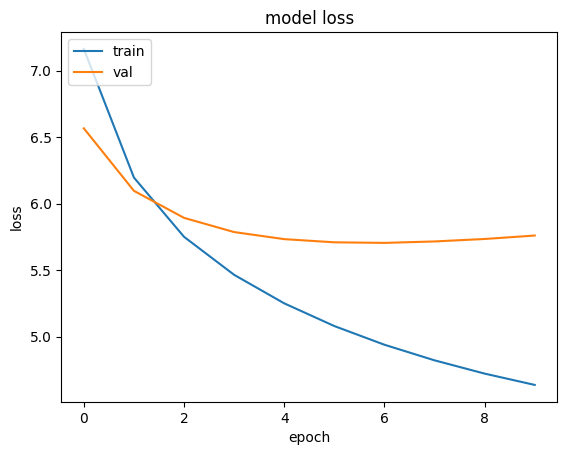

In [42]:
stock_cbow_model = CbowW2V(wiki.word2id)
stock_cbow_model.fit(
    *train_test_split(
        *get_X_y_for_Cbow(wiki),
        test_size=0.05
    )
)

In [19]:
def get_embeddings_from_model(model:SkipgramW2V|CbowW2V):
    embeddings_1 = model.model.layers[0].get_weights()[0]
    embeddings_2 = model.model.layers[2].get_weights()[0].T
    return np.mean([embeddings_1, embeddings_2], axis=0)

In [20]:
embeddings = get_embeddings_from_model(stock_skipgram_model)

In [22]:
def most_similar(word: str, vocab: Vocab, embeddings):
    similar = [
        vocab.id2word[i]
        for i
        in cosine_distances(
            embeddings[vocab.word2id[word]].reshape(1, -1),
            embeddings
        ).argsort()[0][:10]
    ]
    return similar

In [23]:
most_similar('птица', wiki, embeddings)

['птица',
 'влажных',
 'гнездо',
 'лугах',
 'небольшая',
 'зонтики',
 'сибири',
 'ареала',
 'бутоны',
 'ели']

In [24]:
most_similar('церковь', wiki, embeddings)

['церковь',
 'иисуса',
 'деревянная',
 'рига',
 'построенная',
 'павла',
 'собор',
 'значительным',
 'устроена',
 'построена']

In [44]:
embeddings = get_embeddings_from_model(stock_cbow_model)

In [45]:
most_similar('птица', wiki, embeddings)

['птица',
 'блестящий',
 'птицы',
 'семейства',
 'светлая',
 'распространена',
 'жук',
 'подсемейства',
 'изображают',
 'чёрная']

In [46]:
most_similar('церковь', wiki, embeddings)

['церковь',
 'деревянная',
 'освящена',
 'построена',
 'разобрана',
 'православная',
 'христова',
 'храм',
 'богородицы',
 'чудотворца']

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор. 
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%. 

# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.